# Data Analysis of Yelp Business Data
In this project, I will be analyzing a subset of Yelp's business, reviews and user data. The dataset comes from <a href="https://www.kaggle.com/yelp-dataset/yelp-dataset#yelp_academic_dataset_business.json">Kaggle</a>. I have then pulled the data into a publis s3 bucket: s3://sta9760-project2-yelp-data/*.json

# Part I: Installation and Initial Setup

I begin by installing the pandas and matplotlib.

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588562389225_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Import the libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col, abs, split, explode
from pyspark.sql import functions as F

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

In [8]:
df_business = spark.read.json('s3://sta9760-project2-yelp-data/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
print(f'Columns: {len(df_business.dtypes)} | Rows: {df_business.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209393

In [17]:
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

- business_id
- name
- city
- state
- categories

In [3]:
df_business.select('business_id','name','city','state','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Part II: Analyzing Categories

Let's now answer this question: <b>how many unique categories are represented in this dataset</b>?

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

- How many businesses are categorized as Active Life, for instance
- What are the top 20 most popular categories available?

## Association Table
We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:
<table>
<thead>
<tr><th>business_id</th><th>categories</th></tr>
</thead>
<tbody>
<tr><td>abcd123</td><td>a,b,c</td></tr>
</tbody>
</table>

We would like to derive something like:

<table>
<thead>
<tr><th>business_id</th><th>categories</th></tr>
</thead>
<tbody>
<tr><td>abcd123</td><td>a</td></tr>
<tr><td>abcd123</td><td>b</td></tr>
<tr><td>abcd123</td><td>c</td></tr>
</tbody>
</table>

What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

In [4]:
df_business.select('business_id','categories').withColumn("categories", explode(split("categories", ", "))).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|         Active Life|
|f9NumwFMBDn751xgF...|    Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|         Guns & Ammo|
|f9NumwFMBDn751xgF...|            Shopping|
|Yzvjg0SayhoZgCljU...|    Health & Medical|
|Yzvjg0SayhoZgCljU...|Fitness & Instruc...|
|Yzvjg0SayhoZgCljU...|                Yoga|
|Yzvjg0SayhoZgCljU...|         Active Life|
|Yzvjg0SayhoZgCljU...|             Pilates|
|XNoUzKckATkOD1hP6...|                Pets|
+--------------------+--------------------+
only showing top 10 rows

## Total Unique Categories

Finally, we are ready to answer the question: <b>what is the total number of unique categories available?</b>

In [34]:
num_of_unique_categories = df_business.select('business_id','categories').withColumn("categories", explode(split("categories", ", "))).select('categories').distinct().count()
print(f'Number of Unique Categories: {num_of_unique_categories}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of Unique Categories: 1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

<table>
<thead>
<tr><th>category</th><th>count</th></tr>
</thead>
<tbody>
<tr><td>a</td><td>15</td></tr>
<tr><td>b</td><td>2</td></tr>
<tr><td>c</td><td>45</td></tr>
</tbody>
</table>

Or something to that effect.

In [21]:
df_business_categories = df_business.select('business_id','categories').withColumn("categories", explode(split("categories", ", ")))
print(df_business_categories.groupBy('categories').count().show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|         categories|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|      Data Recovery|  195|
|      Videographers|  169|
|      Skating Rinks|  104|
|             Fondue|   54|
|    Pet Photography|   49|
|  Pet Waste Removal|   34|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|       Aerial Tours|   28|
|  Signature Cuisine|    1|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

None

### Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories.

In [23]:
df_business_categories_count = df_business_categories.groupBy('categories').count()
df_business_categories_count_top20 = df_business_categories_count.sort("count", ascending=False).limit(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

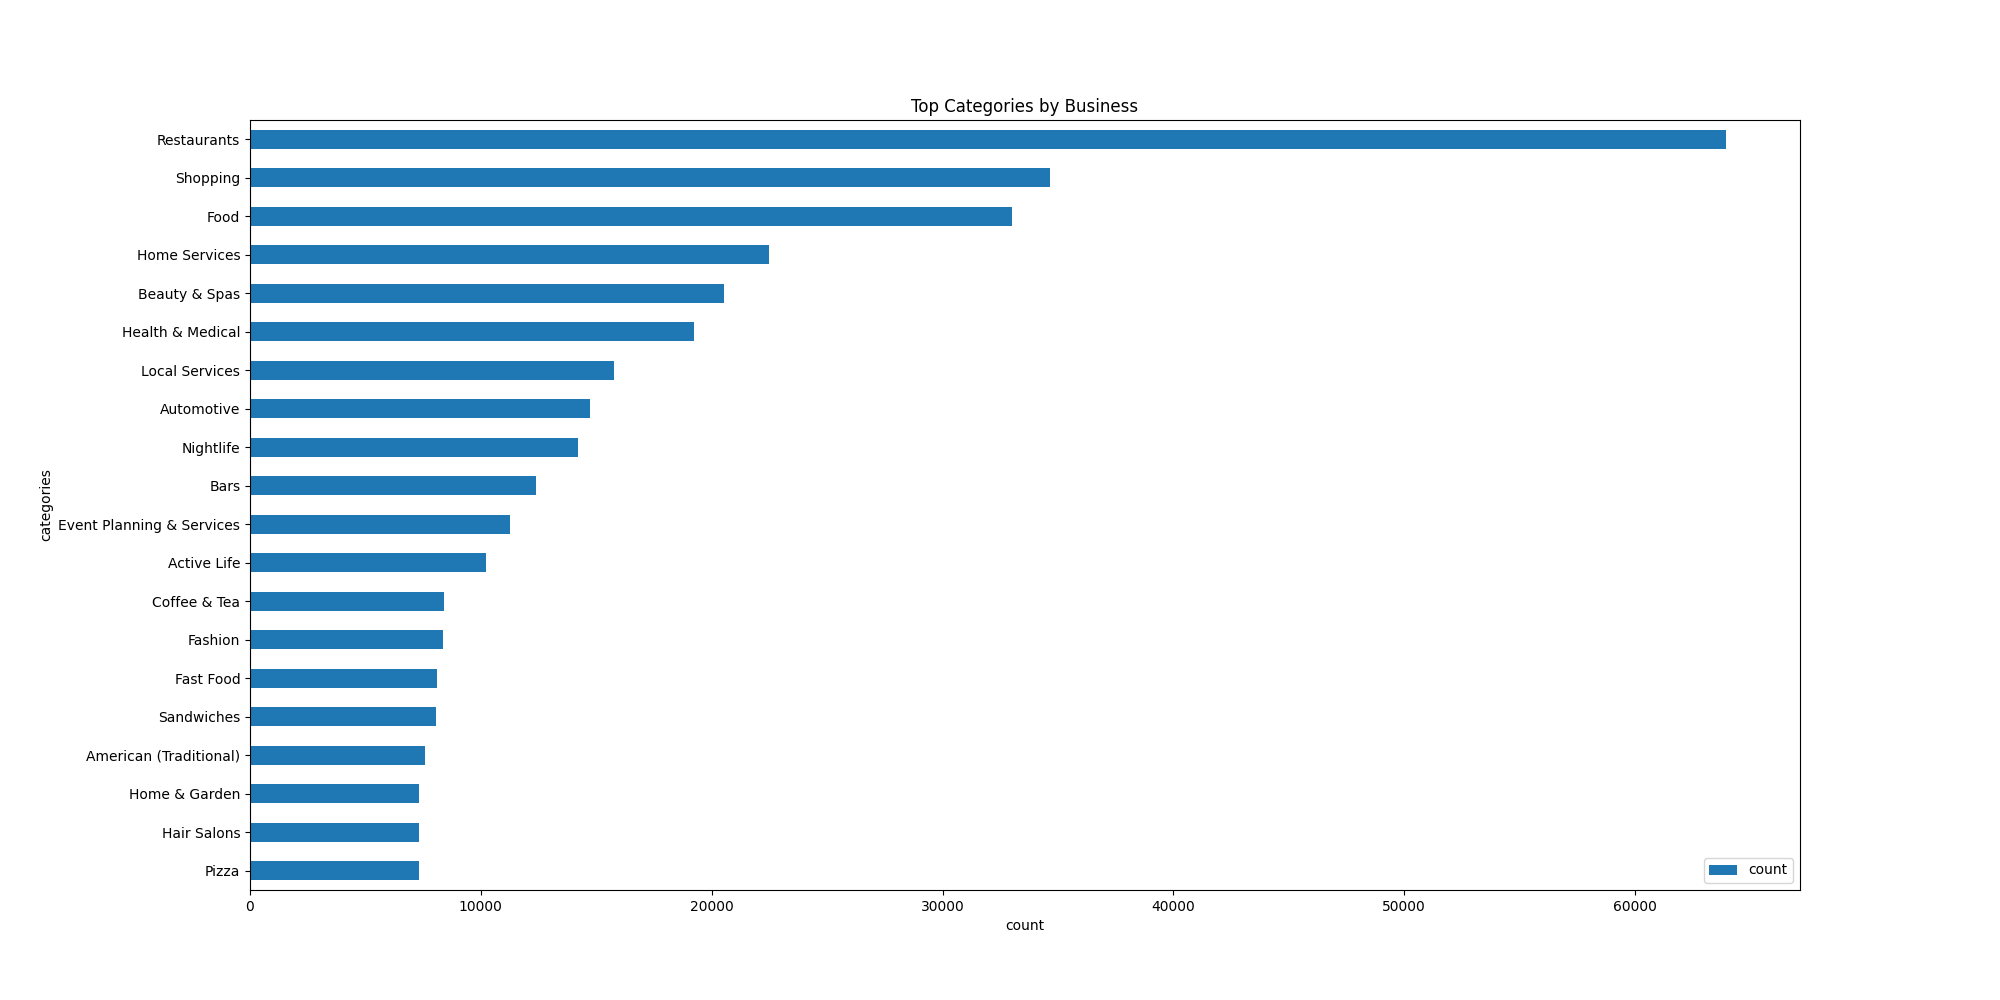

In [46]:
df_business_categories_count_top20_pandas = df_business_categories_count_top20.toPandas().set_index('categories')

# plot
df_business_categories_count_top20_pandas.plot.barh().invert_yaxis()
plt.title('Top Categories by Business')
plt.xlabel("count")
plt.ylabel("categories")
plt.rcParams["figure.figsize"] = [20, 5]

%matplot plt

# Part III: Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

## Loading Review Data

Begin by loading the review data set from S3 and printing schema to determine what data is available.

In [3]:
df_review = spark.read.json('s3://sta9760-project2-yelp-data/yelp_academic_dataset_review.json')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data.

In [6]:
df_review.select('business_id','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who <b>took the time to submit a written review.</b>

In [4]:
df_avg_review_stars = df_review.groupBy('business_id').agg(mean('stars'))
df_avg_review_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by business_id.

In [9]:
df_business_join_avgStars = df_business.join(df_avg_review_stars, on=['business_id'], how='inner')
df_business_join_avgStars.select('avg(stars)','stars','name','city','state').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+
|        avg(stars)|stars|                name|       city|state|
+------------------+-----+--------------------+-----------+-----+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|
+------------------+-----+--------------------+-----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote <b>and</b> actual review and reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the <b>skew</b> is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If <b>skew</b> is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [11]:
df_skew_review = df_business_join_avgStars.withColumn("skew",(df_business_join_avgStars['avg(stars)']-df_business_join_avgStars['stars'])/df_business_join_avgStars['stars']).select('avg(stars)','stars','name','city','state','skew')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
df_skew_review_pandas = df_skew_review.select('skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

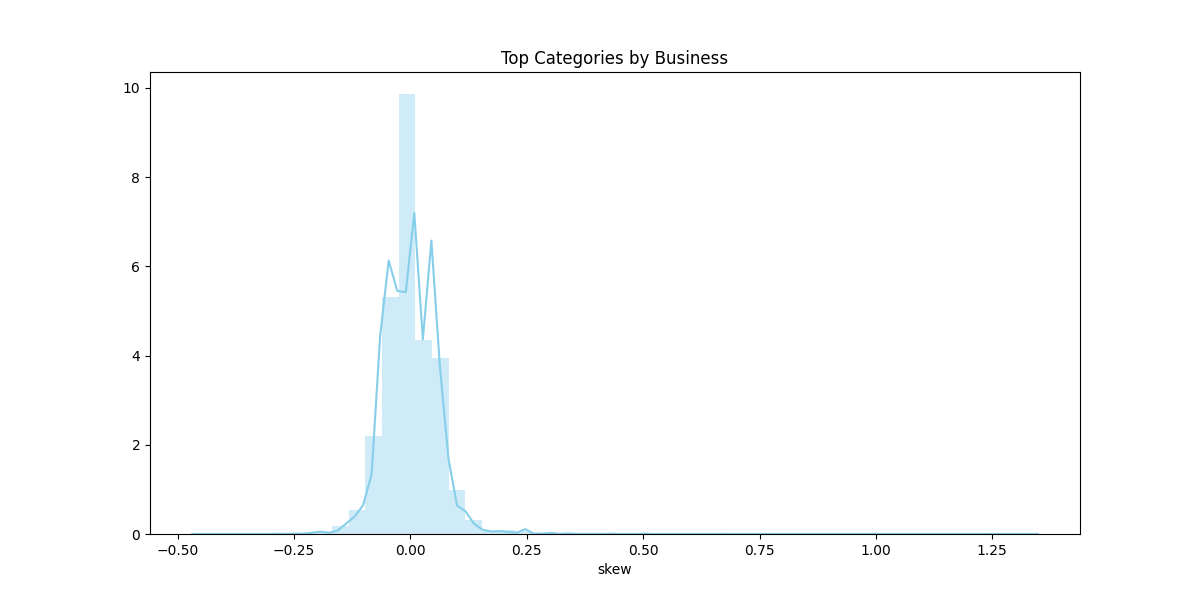

In [53]:
fig = plt.subplots(figsize = (12, 6))
ax = sns.distplot(df_skew_review_pandas, color = 'skyblue')
ax.set_title('Top Categories by Business')
ax.set_xlabel('skew')

%matplot plt

If we look at the shape of the plot above, the plot is pretty close to a normal distribution. So I would not say the Yelp written review is negatively skewed. That means reviewers who left a written response were not more dissatisfied than normal.

# Part IV: Should the Elite be Trusted?

Now I am going to find out if an elite user can be trusted or not by comparing an elite user rating to the actual business rating.

First I will load the user data from s3.

In [7]:
df_user = spark.read.json('s3://sta9760-project2-yelp-data/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The necessary step to do is to first join the business dataframe and the review dataframe using business_id. However, since both dataframe has a column named 'stars', in  order to avoid the joined dataframe has two columns that have the same name, I will first change the name to business_stars and review_stars in the business dataframe and review dataframe, respectively.

In [9]:
df_business = df_business.withColumnRenamed('stars',"business_stars")
df_review = df_review.withColumnRenamed('stars',"review_stars")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df_business_join_review = df_business.join(df_review, on=['business_id'], how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Then, I will join the user dataframe with the df_business_join_review dataframe so that I could see what rating does a  user give to a particular restaurant.

In [11]:
df_business_user_review = df_user.join(df_business_join_review, on=['user_id'], how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's take a look at the dataframe. I am going to filter out the non-elite user.

In [8]:
df_business_user_review.select('business_id','business_stars','review_stars','user_id','elite').sort('business_id','user_id').filter(df_business_user_review['elite'] != '').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+------------+--------------------+--------------------+
|         business_id|business_stars|review_stars|             user_id|               elite|
+--------------------+--------------+------------+--------------------+--------------------+
|--1UhMGODdWsrMast...|           4.0|         4.0|BgTWMo2qRrXINPiM3...|           2017,2018|
|--1UhMGODdWsrMast...|           4.0|         4.0|TzU30D-CjtPP3Xumg...| 2015,2016,2017,2018|
|--1UhMGODdWsrMast...|           4.0|         5.0|ZS_qdLMh1XyXKGTrp...|2014,2015,2016,20...|
|--1UhMGODdWsrMast...|           4.0|         4.0|ZgAzKwganIXImRAMc...|2012,2013,2014,20...|
|--1UhMGODdWsrMast...|           4.0|         5.0|atyCaAjUYatIFDOGK...|           2016,2017|
|--1UhMGODdWsrMast...|           4.0|         4.0|qZlNNWCypJI2FOu0_...| 2015,2016,2017,2018|
|--6MefnULPED_I942...|           3.0|         3.0|1kNsEAhGU8d8xugMu...|2012,2013,2014,20...|
|--6MefnULPED_I942...|           3.0|         1.0|3OJEa4qXzjSOkD_Jq...

Then, I will add a column that represents percentage change between the business actual rating and the rating given by an elite user by using the following formula:

```
(abs(review_stars - business_stars) / business_stars) * 100
```

Here I am using the absolute value of the difference of the business rating and the user rating so all the percentage difference is positive. The reason I am doing this is because I only need to know how much is the difference between the business rating and the user rating. I do not need to know if the user rating is either higher or lower than the business rating.

In [12]:
df_business_user_review = df_business_user_review.withColumn('%_difference',(abs((df_business_user_review['review_stars']-df_business_user_review['business_stars'])*-1)/df_business_user_review['business_stars'])*100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's have a look pf the table.

In [13]:
df_business_user_review = df_business_user_review.select('business_id','business_stars','review_stars','%_difference','user_id','elite').sort('business_id').filter(df_business_user_review.elite!='')
df_business_user_review.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+------------+-----------------+--------------------+--------------------+
|         business_id|business_stars|review_stars|     %_difference|             user_id|               elite|
+--------------------+--------------+------------+-----------------+--------------------+--------------------+
|--1UhMGODdWsrMast...|           4.0|         4.0|              0.0|BgTWMo2qRrXINPiM3...|           2017,2018|
|--1UhMGODdWsrMast...|           4.0|         5.0|             25.0|atyCaAjUYatIFDOGK...|           2016,2017|
|--1UhMGODdWsrMast...|           4.0|         4.0|              0.0|qZlNNWCypJI2FOu0_...| 2015,2016,2017,2018|
|--1UhMGODdWsrMast...|           4.0|         4.0|              0.0|ZgAzKwganIXImRAMc...|2012,2013,2014,20...|
|--1UhMGODdWsrMast...|           4.0|         5.0|             25.0|ZS_qdLMh1XyXKGTrp...|2014,2015,2016,20...|
|--1UhMGODdWsrMast...|           4.0|         4.0|              0.0|TzU30D-CjtPP3Xumg...| 2015,2016,2017,2018|
|

Also let's have a look of some basic statistics of the percentage differnece.

In [88]:
df_business_user_review.describe(['%_difference']).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|      %_difference|
+-------+------------------+
|  count|           1756327|
|   mean|22.936858008715394|
| stddev|21.704982036408218|
|    min|               0.0|
|    max|             400.0|
+-------+------------------+

So now we know the the percentage difference of an elite user rating and a business rating. We can now use this information to create a histgoram. 

In [30]:
df_business_user_review_plot = df_business_user_review.select('%_difference').toPandas()
df_business_user_review_plot.plot.hist(bins=50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

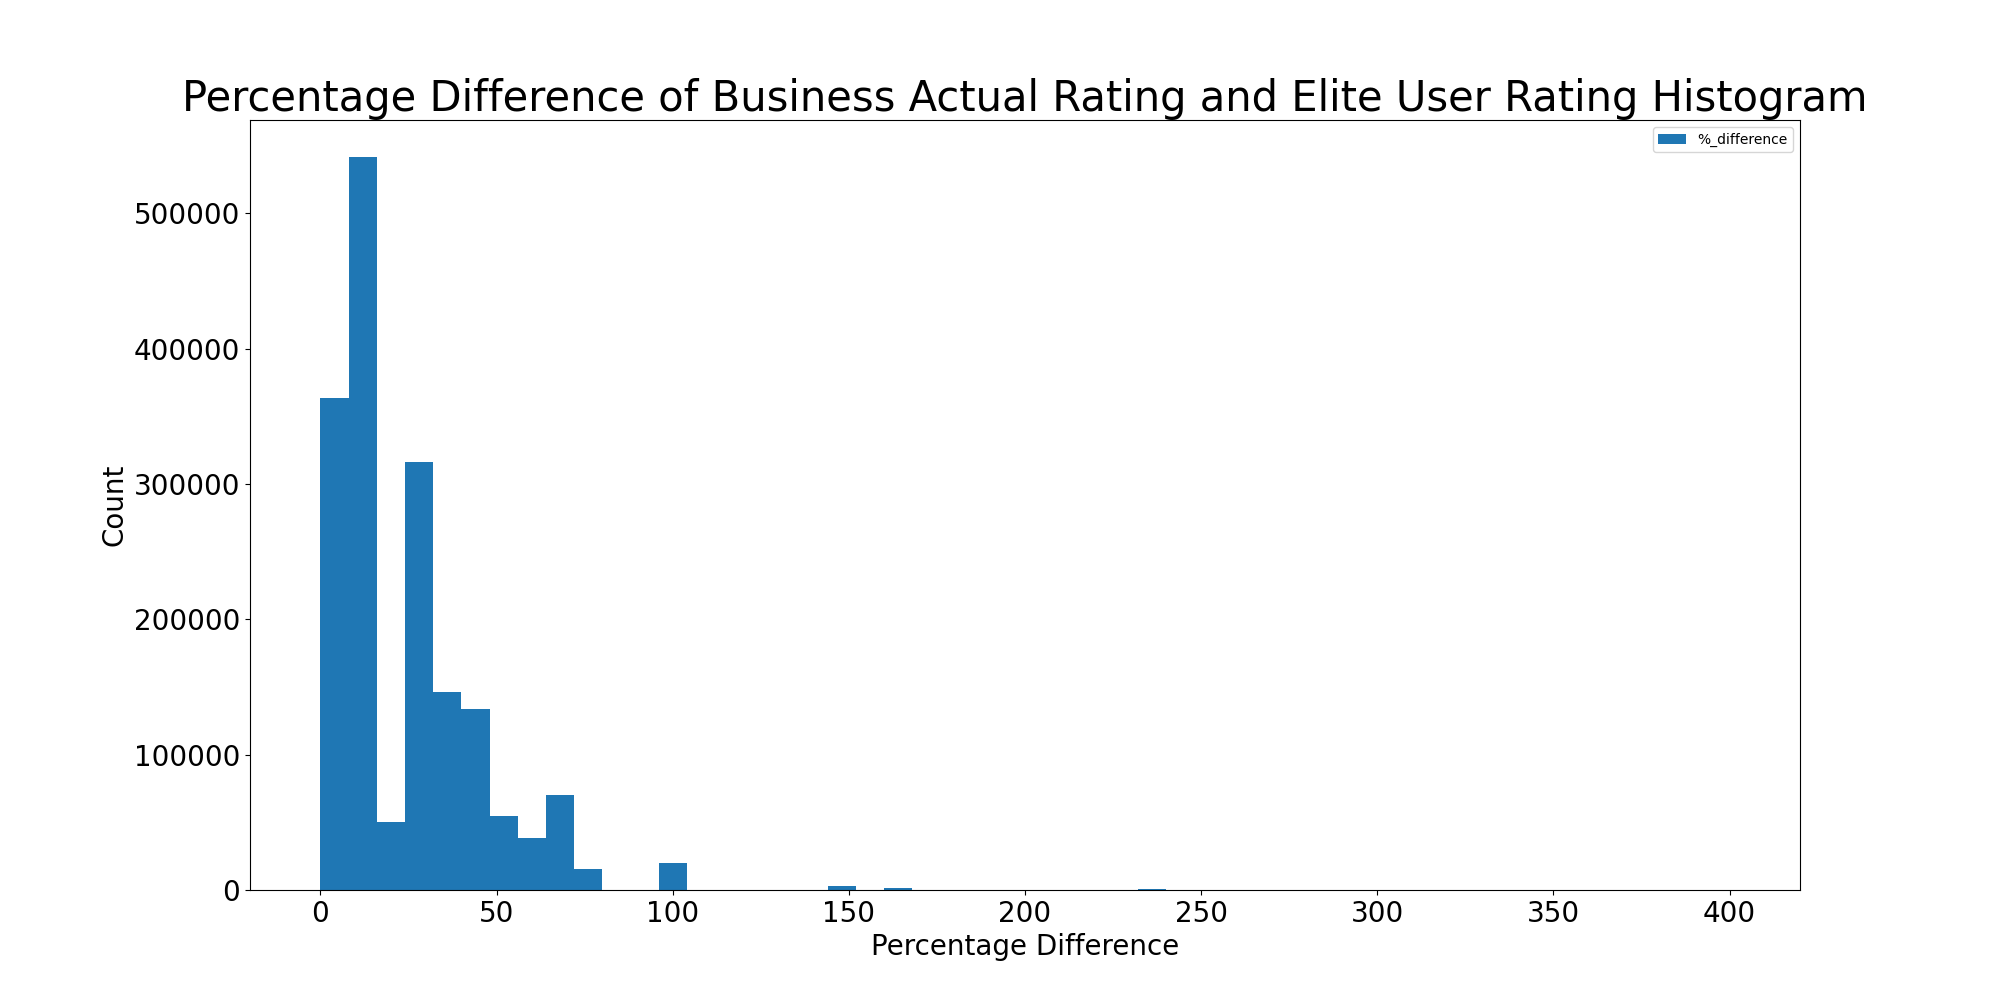

In [37]:
plt.xlabel('Percentage Difference',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Percentage Difference of Business Actual Rating and Elite User Rating Histogram',fontsize=30)

%matplot plt

From the plot above, we could see that most of the elite user review are 50% less different from the actual business review.

In order to have a more clear view of how the elite user reviews is different from the business review, I want to look at the percentage of different range of the percentage difference.

In [14]:
total = df_business_user_review.count()

less_25 = df_business_user_review.filter(df_business_user_review['%_difference'] <= 25).count()
print(f'Percentage Difference <= 25%: {less_25}, Percentage: {(less_25/total)*100}%')

greate_25_less_50 = df_business_user_review.filter(df_business_user_review['%_difference'] > 25).filter(df_business_user_review['%_difference'] <= 50).count()
print(f'Percentage Difference >25 and <= 50%: {greate_25_less_50}, Percentage: {(greate_25_less_50/total)*100}%')

greate_50_less_75 = df_business_user_review.filter(df_business_user_review['%_difference'] > 50).filter(df_business_user_review['%_difference'] <= 75).count()
print(f'Percentage Difference >40 and <= 60%: {greate_50_less_75}, Percentage: {(greate_50_less_75/total)*100}%')

greate_75_less_100 = df_business_user_review.filter(df_business_user_review['%_difference'] > 75).filter(df_business_user_review['%_difference'] <= 100).count()
print(f'Percentage Difference >60 and <= 80%: {greate_75_less_100}, Percentage: {(greate_75_less_100/total)*100}%')

greate_100 = df_business_user_review.filter(df_business_user_review['%_difference'] > 100).count()
print(f'Percentage Difference >100: {greate_100}, Percentage: {(greate_100/total)*100}%')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Percentage Difference <= 25%: 1272432, Percentage: 72.44846773977739%
Percentage Difference >25 and <= 50%: 327383, Percentage: 18.64020766064634%
Percentage Difference >40 and <= 60%: 128128, Percentage: 7.295224636414517%
Percentage Difference >60 and <= 80%: 23450, Percentage: 1.3351727781899385%
Percentage Difference >100: 4934, Percentage: 0.280927184971819%

Now I will create a dataframce using the data above and plot it.

In [15]:
df_percentage = spark.createDataFrame(
    [
        ('[0%,25%]', (less_25/total)*100), 
        ('(25%,50%]', (greate_25_less_50/total)*100),
        ('(50%,75%]', (greate_50_less_75/total)*100),
        ('(75%,100%]', (greate_75_less_100/total)*100),
        ('(100%,∞)', (greate_100/total)*100),
    ],
    ['Difference_Percentage_Range', 'Percentage'] 
)

df_percentage.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------+------------------+
|Difference_Percentage_Range|        Percentage|
+---------------------------+------------------+
|                   [0%,25%]| 72.44846773977739|
|                  (25%,50%]| 18.64020766064634|
|                  (50%,75%]| 7.295224636414517|
|                 (75%,100%]|1.3351727781899385|
|                   (100%,∞)| 0.280927184971819|
+---------------------------+------------------+

In [16]:
df_percentage_pandas = df_percentage.toPandas()
df_percentage_pandas = df_percentage_pandas.set_index('Difference_Percentage_Range')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

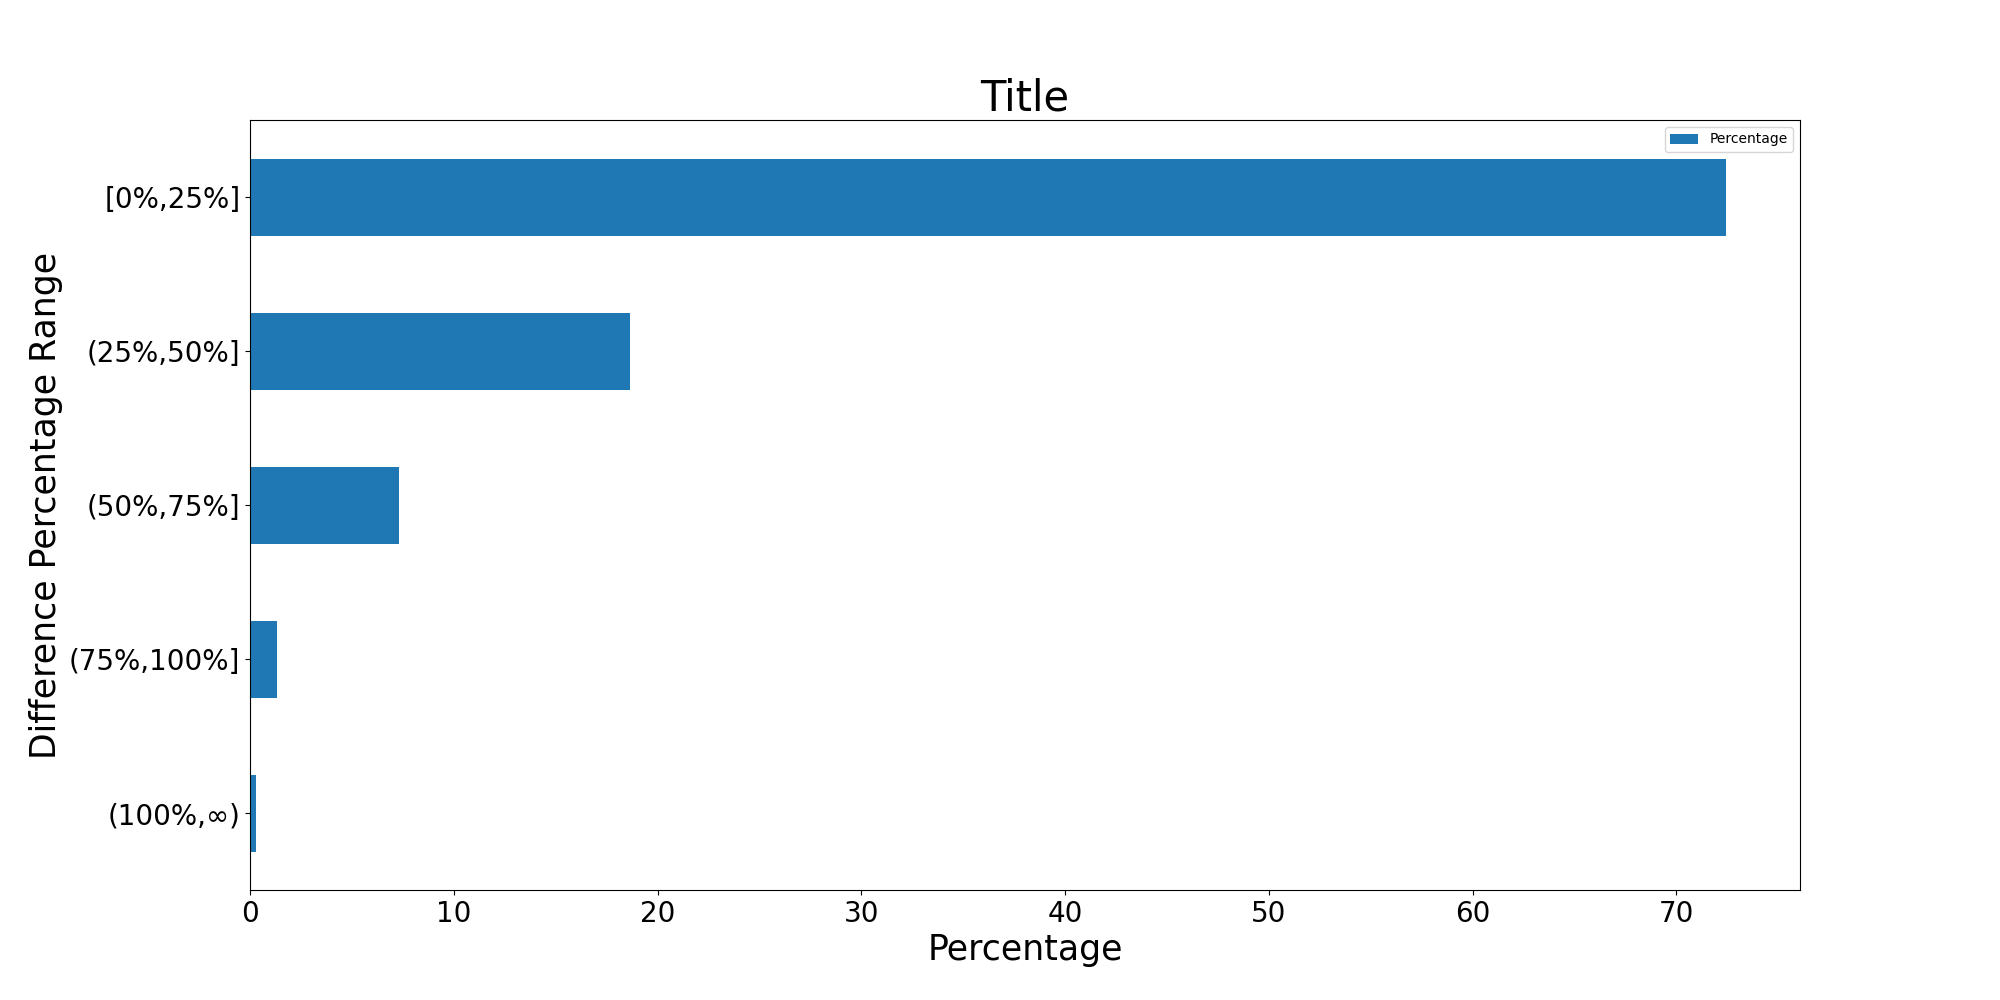

In [99]:
df_percentage_pandas.plot.barh().invert_yaxis()
plt.title('Title',fontsize=30)
plt.xlabel('Percentage',fontsize=25)
plt.ylabel('Difference Percentage Range',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
%matplot plt

So finally we have the information allow us to answer the question: <b>should we trust the elite user's rating?</b>

If we look at the data and the plot above, we could see that most of the eilte user review is not so different from the actual business review. 72% of the eilte user review is at most 25% different from the actual business review. And there is only about 8.9% of the eilte user review is 50% different from the actual business review. So based on this observations, I would say the eilte user's raing can be trusted.